In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

N= 50
T= 7
R= 0.8
M= 5
F= 0.005

In [2]:
def GetData(file_name):
    return pd.read_csv(file_name, usecols= [1,2,3])
df= GetData('DATA.csv')
df.head(1055)

,datadate,tic,adjcp
0,20090102,AAPL,12.964286
1,20090102,AXP,19.330000
2,20090102,BA,45.250000
3,20090102,CAT,46.910000
4,20090102,CSCO,16.960000
...,...,...,...
1050,20090224,AAPL,12.892857
1051,20090224,AXP,13.620000
1052,20090224,BA,35.440000
1053,20090224,CAT,26.040000


In [3]:
def PartitionData(data):
    date_to_index={}
    i=0
    while(i<87779):
        date_to_index[str(data['datadate'][i])]= i
        i+=30
        
    
    
    return np.array_split(data,2926),date_to_index
          
f,g= PartitionData(df)

In [4]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):


    NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
    NdaysAgo_date= NdaysAgo.strftime("%Y") + NdaysAgo.strftime("%m") + NdaysAgo.strftime("%d")
    
    if NdaysAgo_date not in DateToIndex:
        
        i=0
        while True:
            NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N-i)
            NdaysAgo_date= NdaysAgo.strftime("%Y") + NdaysAgo.strftime("%m") + NdaysAgo.strftime("%d")
            if NdaysAgo_date in DateToIndex:
                break
            else:
                i+=1
                
    f=PartitionedDataFrameList
    g=DateToIndex
    diff= np.array([(f[int(g[today]/30)]['adjcp'][g[today]+j] - f[int(g[NdaysAgo_date]/30)]['adjcp'][g[NdaysAgo_date]+j]) for j in range(0,30)])
    
    total= np.array(f[int(g[today]/30)]['adjcp'])
    
    for i in range( g[NdaysAgo_date] , g[today] ,30 ):
        
        total += np.array(f[int(i/30)]['adjcp'])

    momentum_mean= (diff * N)/total
    return momentum_mean
            
print(GetMomentumBasedPriority(f, g ,'20090225') )  
            

[-0.02907086 -0.69303671 -0.43092364 -0.87356264 -0.27023158 -0.28085672
 -1.01057801 -0.49380435  0.02070549 -0.32073711 -0.0529597  -0.24546313
 -0.14292984 -0.47828638 -0.07744959 -0.19366267 -0.34125804 -0.10225659
 -0.29215038 -0.31702364 -0.43232153 -0.31840346 -0.39440977 -0.18934631
 -0.18174771 -0.06067423 -0.16084602 -0.17183241 -0.19611683 -0.15424885]


In [5]:
def GetBalanced(prices, weights, balance):
    
    to_invest= balance*R
    
    tot= np.sum(weights)
    weights= weights/tot
    
    return weights*to_invest
    
    
    
    

In [14]:
class PortFolio:
    def __init__(self,balance,shares):
        self.balance = balance
        self.shares = shares
        self.prices = np.zeros(30, dtype= float)


    def SellStock(self,index):
        self.balance = self.balance + self.shares[index]*self.prices[index]*(1-F)
        self.shares[index] = 0
        

    def BuyStock(self,index,number):
        self.balance = self.balance -self.prices[index]*number*(1+F)
        self.shares[index] += number

    def CalculateNetWorth(self):
        net_worth = self.balance
        for i in range(0,30):
            net_worth += self.prices[i]*self.shares[i]
        return net_worth 


    def ChangePricesTo(self, newPriceVector):
        self.prices = newPriceVector


    def RebalancePortFolio(self, newWeights):  
        
        for i in range(0,30):
            self.SellStock(i) 
            
        weight = np.zeros(30, dtype= float)
        x = 0
        for i in range(0,30):
            if(newWeights[i] < 0):
                pass
            else:
                weight[i] = newWeights[i]
                x += 1
        m= min(x,M)
        a = np.copy(weight)
        for t in a:
            if( t== 0):
                a = np.delete(a,np.where(a == t))
        a = np.sort(a)[::-1]  
        while(len(a)!= m):
            a = np.delete(a,len(a)-1)
        for i in range(0,len(weight)):
            if(weight[i] in a):
                pass
            else:
                weight[i] = 0
    
        
        stock = GetBalanced(self.prices,weight,self.balance)  
        for i in range(0,30):
            self.BuyStock(i,stock[i])

In [19]:
balance = 1000
Data = GetData('DATA.csv')
myPortfolio = PortFolio(balance, np.zeros(30, dtype= float))
NetWorthAfterEachTrade = []
NetWorthAfterEachTrade.append(balance)

PartitionedData, DateToIndex= PartitionData(Data)

t = T
for i in range(N+1,len(DateToIndex.keys())):
    for j in range(30):
        myPortfolio.prices[j] = PartitionedData[i].iloc[j]['adjcp']
    NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth())
    if(t != T):
        t += 1
        continue
    else:
        t = 0
        if(myPortfolio.balance < R*balance):
            continue
    myPortfolio.RebalancePortFolio(GetMomentumBasedPriority(PartitionedData, DateToIndex ,list(DateToIndex.keys())[i]))

In [20]:

def VisualizeData(list,d1,d2):
    
    x=(np.array([i for i in range(d1,d2)])).T
    plt.plot(x.T, list[d1:d2])
    plt.xlabel('days')
    plt.ylabel('networth')
    plt.show()


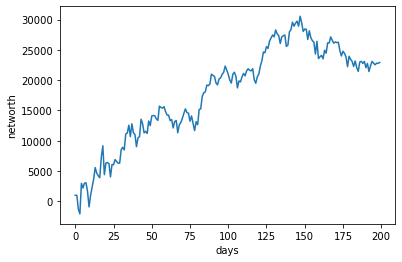

In [21]:
VisualizeData(NetWorthAfterEachTrade,0,200)